In [ ]:
# https://poalim.tistory.com/m/29
# https://github.com/poArlim/crypto-auto-trading


import pyupbit
import pandas as pd
import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 한글 폰트 설정 (Mac: AppleGothic)
plt.rc('font', family='AppleGothic')     # Mac: 
matplotlib.rcParams['axes.unicode_minus'] = False

# plt.rc('font', family='NanumGothic')   # Linux: 나눔고딕
# plt.rc('font', family='Malgun Gothic') # Windows:

In [24]:
# K의 역할
# K는 변동폭을 얼마나 반영할지 결정하는 조정 계수입니다.
# K = 1: 전날 변동폭 100% 반영.
# → 목표 매수가 = 시가 + 전날 변동폭 전체.
# K = 0: 전날 변동폭을 전혀 반영하지 않음.
# → 목표 매수가 = 시가.

# 0 < K < 1: 전날 변동폭을 부분적으로 반영.
# → 목표 매수가는 시가와 변동폭의 비율에 따라 조정됨.
# K는 매수 기준을 조정하는 변수입니다.
# 높은 K는 더 큰 변동성을 노리지만, 거래 빈도가 줄어들 수 있습니다.
# 낮은 K는 더 자주 거래하지만, 변동성 활용도가 낮아질 수 있습니다.
# 적절한 K 값을 찾기 위해 백테스트가 필요합니다.

# K가 수익에 미치는 영향
# K 값에 따라 매수 타이밍이 달라지며, 수익률과 리스크가 변합니다:
# K가 높을수록 (1에 가까울수록):
# 더 높은 변동성을 목표로 매수.
# → 큰 가격 움직임을 노리지만, 매수 확률이 낮아질 수 있음.
# K가 낮을수록 (0에 가까울수록):
# 작은 변동성에도 매수.
# → 매수 기회가 많아지지만, 수익률이 낮아질 가능성이 있음.

coin = "KRW-BTC"		# 코인명
interval = "day"		# 일간 차트 기준
fees = 0.0005			# 수수료(0.05% = 0.0005, 즉 0.05/100)
day_count = 1300		# 가져오는 총 데이터 일 수(1300일치 데이터)
k = 0.5                 # K 값(0 < K < 1, 0.5는 50% 반영)

예시로 100만원(1,000,000원)을 시작 자금으로  
1) 변동성 돌파 전략  
2) 아무 전략 없이 단순 보유  
두 방식의 차이

---

### 1. 변동성 돌파 전략

- **매일 아침**:  
  - 목표가(시가 + 전일 변동폭 × k)가 정해짐
- **그날 고가가 목표가를 넘으면**:  
  - 목표가에 매수, 종가에 매도 (수수료 반영)
  - 수익 또는 손실 발생 → 다음날 또 반복
- **그날 고가가 목표가를 못 넘으면**:  
  - 매수 안 함, 자금 그대로 유지

이렇게 매일 반복해서  
- 매수/매도 타이밍이 전략에 따라 달라지고  
- 매일 수익률이 누적(복리)로 계산됨

---

### 2. 아무 전략 없이 단순 보유

- **첫날 시가에 100만원 전액 매수**
- **마지막 날 종가에 전액 매도** (수수료 반영)
- 중간에 추가 매수/매도 없음

즉,  
- 그냥 100만원을 처음부터 끝까지 들고만 있다가  
- 마지막에 한 번에 판다고 생각

---

### 결과 계산 예시

- **변동성 돌파 전략**:  
  - 매일 전략에 따라 수익/손실이 쌓여  
  - 마지막 날 자산 = 100만원 × (누적 수익률 + 1)
- **단순 보유**:  
  - 마지막 날 자산 = 100만원 × (마지막날 종가 / 첫날 시가) (수수료 반영)

---

**정리:**  
- 변동성 돌파: 매일 전략적으로 사고팔아서 복리로 불어남  
- 단순 보유: 처음 사고 마지막에 파는 단순 투자  
- 두 방식의 누적 수익률을 비교해서 전략의 효과를 확인할 수 있다.

In [28]:
date = None             # 데이터를 반복적으로 가져올 때 기준 날짜를 설정
dfs = []                # 가져온 데이터를 저장할 리스트

# 업비트는 한번에 200 데이터만 반환하기 때문에 데이터를 나누어 여러번 요청
# day_count // 200: 데이터를 200일씩 분할
# +1: 남은 데이터를 처리하기 위해 추가 반복
for i in range(day_count // 200 + 1):

    # 초기 데이터 요청
    # 첫 번째 요청 시 date는 None이므로 가장 최신 데이터를 가져옴
    # df.index[0]: 반환된 데이터의 첫 번째 날짜를 가져와 date에 저장
    if i < day_count // 200 :
        df = pyupbit.get_ohlcv(coin, to = date, interval = interval)
        date = df.index[0]

    # 남은 데이터 요청
    # elif day_count % 200 != 0: 요청한 총 데이터가 200의 배수가 아닐 경우 남은 데이터를 가져옴
    elif day_count % 200 != 0 :
        df = pyupbit.get_ohlcv(coin, to = date, interval = interval, count = day_count % 200)
    
    # 필요한 데이터를 모두 가져왔으면 반복을 종료
    else :
        break
    dfs.append(df)
    time.sleep(0.1)

# 각 반복에서 가져온 데이터를 dfs 리스트에 저장한 후, Pandas의 concat 함수를 이용해 병합.
# 날짜순으로 정렬하여 최종 데이터프레임(df) 생성.
df = pd.concat(dfs).sort_index()
df = df.rename(columns={
    "open": "open(시가)",
    "high": "high(고가)",
    "low": "low(저가)",
    "close": "close(종가)",
    "volume": "volume(거래량)",
    "value": "value(거래대금)"
})
print(len(dfs), "번의 요청으로", len(df), "개의 데이터가 수집되었습니다.")

# 최근 1년(365일) 데이터만 사용 (1300개 전체 사용하려면 아래 줄을 주석 처리)
df = df.tail(365)

display(df)

# 3.1 변동성 돌파 전략
# range: 전일 고가와 저가의 차이를 계산.
# targetPrice: 당일 시가에 전일 변동폭의 50%를 더한 값.
df['range'] = df['high(고가)'].shift(1) - df['low(저가)'].shift(1)  # 전일 변동폭
df['targetPrice'] = df['open(시가)'] + df['range'] * k             # 목표 매수가

# 3.2 수익률 계산
# drr: 단일 거래 수익률. 목표가를 초과하면 수익률 계산, 아니면 0.
# crr: 누적 수익률. cumprod를 사용해 매일의 수익률을 곱.
# dd: 최대 손실률. 누적 수익률의 최고점과 현재값의 차이를 계산.
df['drr'] = np.where(
    df['high(고가)'] > df['targetPrice'],
    (df['close(종가)'] / (1 + fees)) / (df['targetPrice'] * (1 + fees)) - 1,
    0
)  # 일별 전략 수익률(수수료 반영)

# 기간 수익률: 알고리즘을 적용한 경우의 최종 수익률.
# 최대 손실률: 투자 기간 중 손실의 최대치.
# 수수료: 매매 시 적용된 수수료 비율.
# 알고리즘 미적용 수익률: 단순히 매수 후 홀딩했을 때의 수익률.
df['crr'] = (df['drr'] + 1).cumprod() - 1                          # 누적 수익률
df['dd'] = -(((df['crr'] + 1).cummax() - (df['crr'] + 1)) / (df['crr'] + 1).cummax())  # 최대 낙폭(드로우다운)
print("기간수익률 :", df['crr'].iloc[-1] * 100, "% , 최대손실률 :", df['dd'].min() * 100, "% , 수수료 :", fees * 100, "%")
print("알고리즘 적용 없을 시 수익률 :", ((df['close(종가)'].iloc[-1]/(1+fees))/(df['open(시가)'].iloc[0]*(1+fees))-1) * 100, "%")


7 번의 요청으로 1300 개의 데이터가 수집되었습니다.


,open(시가),high(고가),low(저가),close(종가),volume(거래량),value(거래대금)
2024-08-03 09:00:00,86691000.0,87690000.0,85000000.0,85957000.0,4059.375137,3.504715e+11
2024-08-04 09:00:00,85954000.0,86311000.0,81684000.0,81871000.0,4532.633978,3.802901e+11
2024-08-05 09:00:00,81871000.0,82256000.0,72100000.0,77833000.0,23878.792672,1.828234e+12
2024-08-06 09:00:00,77786000.0,82150000.0,77782000.0,80224000.0,7868.467001,6.304490e+11
2024-08-07 09:00:00,80166000.0,81950000.0,77782000.0,78388000.0,5316.477661,4.258269e+11
...,...,...,...,...,...,...
2025-07-28 09:00:00,162548000.0,162985000.0,161391000.0,162483000.0,1461.599378,2.371703e+11
2025-07-29 09:00:00,162483000.0,163800000.0,162034000.0,163158000.0,1487.534324,2.426350e+11
2025-07-30 09:00:00,163248000.0,163708000.0,161800000.0,163118000.0,1209.086733,1.969072e+11
2025-07-31 09:00:00,163118000.0,164300000.0,161138000.0,161398000.0,1460.987469,2.383485e+11


기간수익률 : 19.2942543637701 % , 최대손실률 : -17.75512792552547 % , 수수료 : 0.05 %
알고리즘 적용 없을 시 수익률 : 85.01063816402643 %


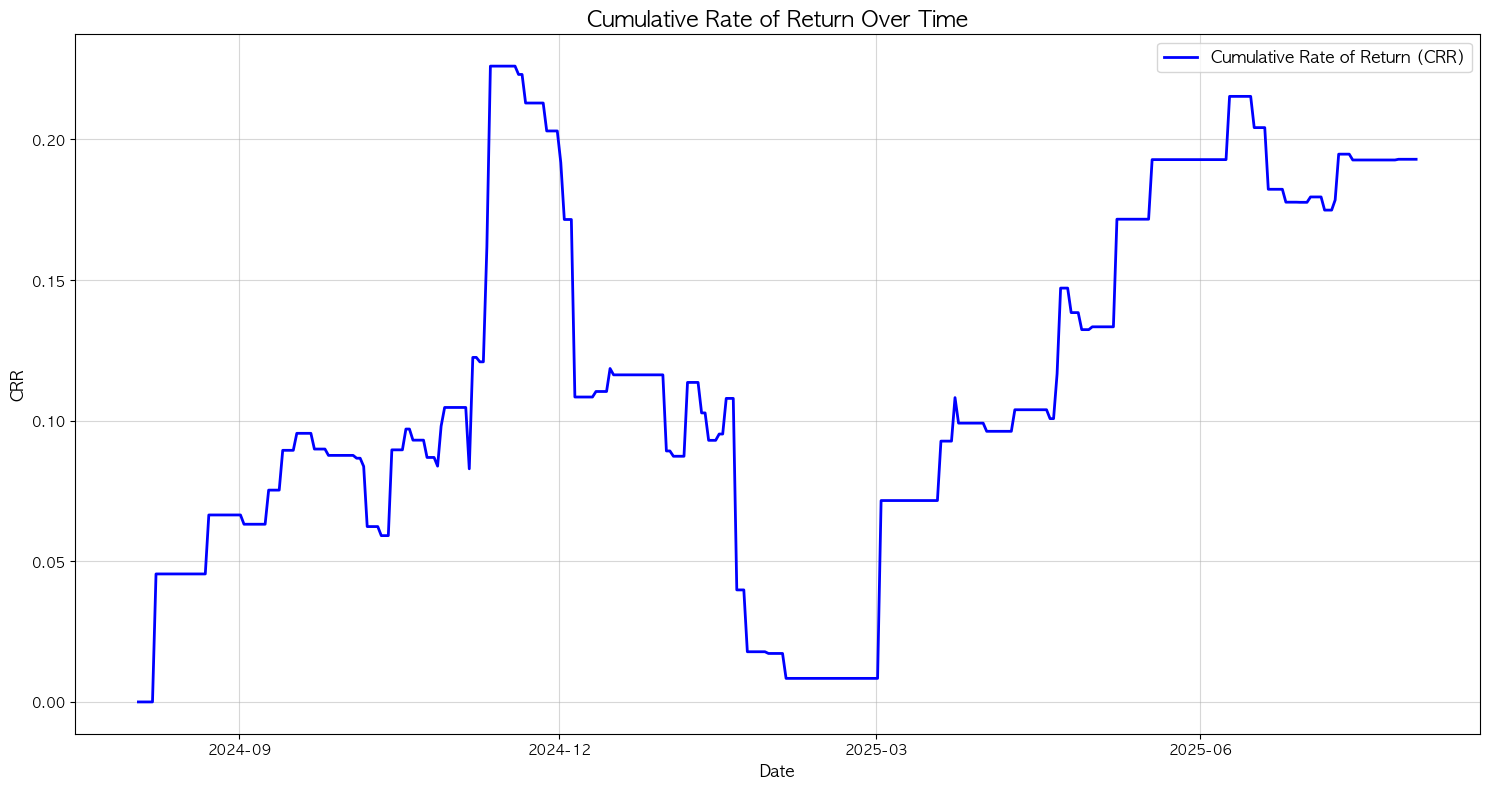

/var/folders/d9/xb3pxm293r15sx57hh9pcrh80000gn/T/ipykernel_82312/1743506376.py:30: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  plt.tight_layout()


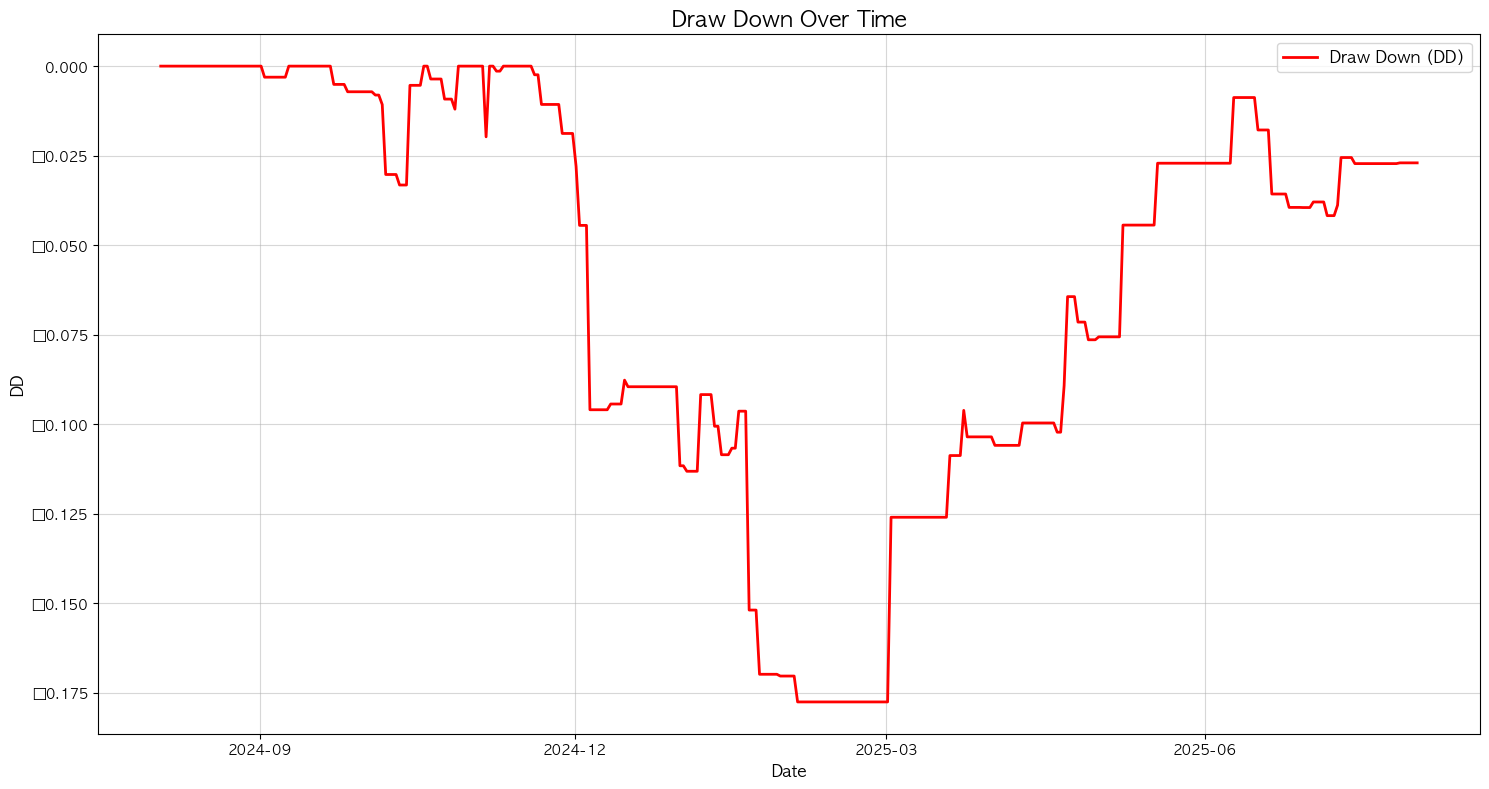

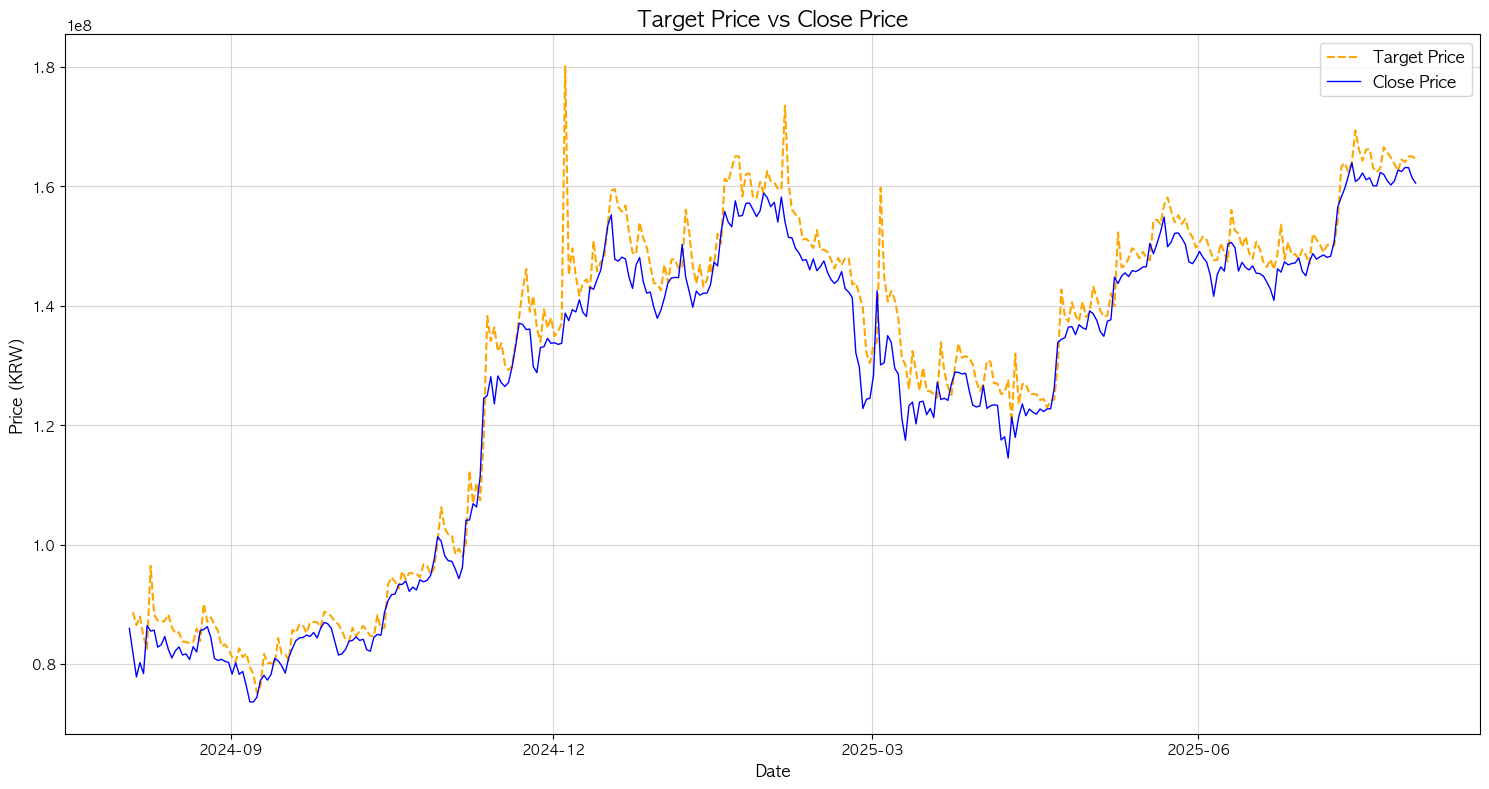

In [32]:
# Visualization

# 1. 누적 수익률(CRR) 그래프
# 전략을 썼을 때 자산이 시간에 따라 얼마나 불어났는지(복리 누적)를 보여줍니다.
# Plotting Cumulative Rate of Return (CRR)
plt.figure(figsize=(15, 8))
plt.plot(df.index, df['crr'], label="Cumulative Rate of Return (CRR)", linewidth=2, color='blue')
plt.title("Cumulative Rate of Return Over Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("CRR", fontsize=12)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # 3개월 단위
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # 연-월 형식
plt.grid(alpha=0.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# 2. 최대 낙폭(드로우다운, DD) 그래프
# 투자 중 최고점 대비 얼마나 하락했는지(위험, 드로우다운)를 보여줍니다.
# Plotting Draw Down (DD)
plt.figure(figsize=(15, 8))
plt.plot(df.index, df['dd'], label="Draw Down (DD)", color='red', linewidth=2)
plt.title("Draw Down Over Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("DD", fontsize=12)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # 3개월 단위
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # 연-월 형식
plt.grid(alpha=0.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# 3. 목표가 vs 종가 그래프
# 매일의 목표 매수가(targetPrice)와 실제 종가(close(종가))를 비교해서
# 전략의 진입 타이밍과 시장 움직임을 시각적으로 확인할 수 있습니다.
# Plotting Target Price vs Close Price
plt.figure(figsize=(15, 8))
plt.plot(df.index, df['targetPrice'], label="Target Price", color='orange', linestyle='--')
plt.plot(df.index, df['close(종가)'], label="Close Price", color='blue', linewidth=1)
plt.title("Target Price vs Close Price", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Price (KRW)", fontsize=12)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # 3개월 단위
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # 연-월 형식
plt.grid(alpha=0.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


K 값별 누적 수익률, 최대 손실률 및 점수:
     K 값  누적 수익률 (CRR)  최대 손실률 (DD)        점수
63  0.68      0.397189    -0.106664  0.290525
65  0.70      0.385092    -0.112310  0.272781
64  0.69      0.382672    -0.111407  0.271266
60  0.65      0.373944    -0.123220  0.250724
66  0.71      0.353337    -0.116838  0.236499
..   ...           ...          ...       ...
2   0.07      0.058525    -0.299649 -0.241124
17  0.22      0.001787    -0.254409 -0.252622
3   0.08      0.012656    -0.300166 -0.287510
6   0.11      0.000346    -0.301368 -0.301022
7   0.12     -0.028248    -0.308997 -0.337245

[96 rows x 4 columns]

**최적 K 값 추천 결과**
최적 K 값: 0.7
최적 누적 수익률 (CRR): 39.72%
최대 손실률 (DD): -10.67%
점수 (CRR - DD): 0.2905

**K 값 선택 기준**
1. 높은 누적 수익률과 낮은 최대 손실률을 동시에 고려.
2. 점수(누적 수익률(CRR) - 최대 손실률(DD))가 가장 높은 값을 선택.
3. 추천: K=0.7는 39.72%의 누적 수익률과 -10.67%의 최대 손실률을 제공합니다.
4. 점수가 높은 K 값일수록 수익률 대비 위험이 적음


/var/folders/d9/xb3pxm293r15sx57hh9pcrh80000gn/T/ipykernel_82312/1602482146.py:105: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  plt.tight_layout()
/Users/kimdonghyeon/2025/개발/Bitcoin-Auto-Bot /.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


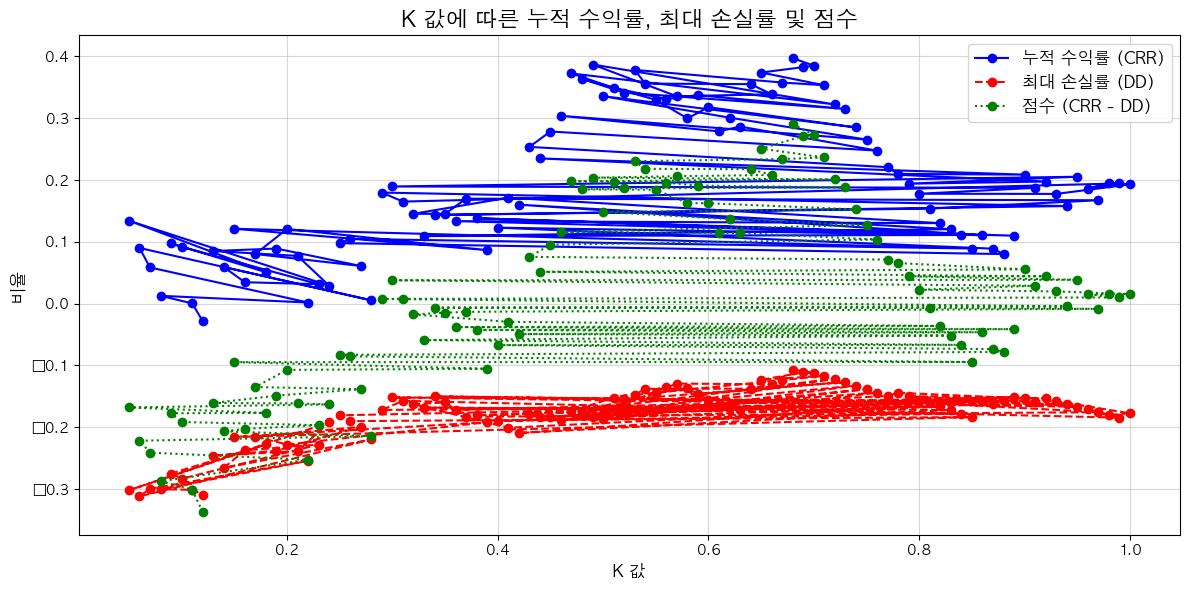

In [33]:
# 전날 고가: 100원, 저가: 90원 → 변동폭: 10원.
# 오늘 시가(시작 가격): 95원.
# 목표가: 95원 + (변동폭 × K) (K는 0.5 같은 설정 값).
# 만약 K=0.5라면, 목표가 = 95 + (10 × 0.5) = 100원.
# 오늘 가격이 100원을 넘으면 매수, 그날 종가에 매도.

# 전날 고가: 100,000원
# 전날 저가: 90,000원
# 전날 변동폭: 고가 - 저가 = 10,000원
# 오늘 시가: 95,000원
# K 값: 0.3

# 계산
# 목표가 설정:
# 목표가 = 오늘 시가 + (전날 변동폭 × K)
# 목표가 = 95,000 + (10,000 × 0.3) = 95,000 + 3,000 = 98,000원

# 매수/매도 시점
# 매수:
# 오늘의 가격이 98,000원을 넘으면 매수.
# 예를 들어, 오늘 가격이 오전 10시에 98,500원을 기록하면 매수 실행.
# 매도:
# **종가(하루의 마지막 가격)**에 매도.
# 예를 들어, 오늘 종가가 100,000원이라면 매도.

# 결과 계산
# 수익률 (수수료는 무시):
# 매수 가격: 98,500원
# 매도 가격: 100,000원
# 수익률 = (매도 가격 / 매수 가격 - 1) × 100
# 수익률 = (100,000 / 98,500 - 1) × 100 ≈ 1.52%

# 요약
# K = 0.3일 때, 오늘 목표가는 98,000원으로 설정.
# 목표가를 넘는 순간 매수하고, 하루가 끝나는 종가에 매도.
# 이 경우 1.52%의 수익률을 기록.

# K 값에 따른 누적 수익률과 최대 손실률 계산
best_k = 0
best_score = -float('inf')  # 초기값 설정
results = []

for k in np.arange(0.05, 1.01, 0.01):  # 1.00까지 포함하려면 1.01로
    df['range'] = df['high(고가)'].shift(1) - df['low(저가)'].shift(1)
    df['targetPrice'] = df['open(시가)'] + df['range'] * k
    df['drr'] = np.where(df['high(고가)'] > df['targetPrice'], 
                         (df['close(종가)'] / (1 + fees)) / (df['targetPrice'] * (1 + fees)) - 1, 0)
    df['crr'] = (df['drr'] + 1).cumprod() - 1
    dd = -(((df['crr'] + 1).cummax() - (df['crr'] + 1)) / (df['crr'] + 1).cummax())  # 최대 손실률 계산
    crr = df['crr'].iloc[-1]  # 최종 누적 수익률
    score = crr - abs(dd.min())  # 점수 계산 (수익률 - 손실률)
    results.append((k, crr, dd.min(), score))  # 결과 저장
    
    if score > best_score:  # 점수 기준으로 최적 값 갱신
        best_k = k
        best_score = score

# 결과를 데이터프레임으로 정리
result_df = pd.DataFrame(results, columns=["K 값", "누적 수익률 (CRR)", "최대 손실률 (DD)", "점수"])
result_df = result_df.sort_values(by="점수", ascending=False)

# 최적 K 값 정보
optimal_result = result_df.iloc[0]
optimal_k = optimal_result["K 값"]
optimal_crr = optimal_result["누적 수익률 (CRR)"]
optimal_dd = optimal_result["최대 손실률 (DD)"]
optimal_score = optimal_result["점수"]

# 결과 출력
print("\nK 값별 누적 수익률, 최대 손실률 및 점수:")
print(result_df)

print("\n**최적 K 값 추천 결과**")
print(f"최적 K 값: {optimal_k:.1f}")
print(f"최적 누적 수익률 (CRR): {optimal_crr * 100:.2f}%")
print(f"최대 손실률 (DD): {optimal_dd * 100:.2f}%")
print(f"점수 (CRR - DD): {optimal_score:.4f}")

# 선택 기준 설명
print("\n**K 값 선택 기준**")
print("1. 높은 누적 수익률과 낮은 최대 손실률을 동시에 고려.")
print("2. 점수(누적 수익률(CRR) - 최대 손실률(DD))가 가장 높은 값을 선택.")
print(f"3. 추천: K={optimal_k:.1f}는 {optimal_crr * 100:.2f}%의 누적 수익률과 {optimal_dd * 100:.2f}%의 최대 손실률을 제공합니다.")
print("4. 점수가 높은 K 값일수록 수익률 대비 위험이 적음")





# 시각화
k_values = result_df["K 값"]
crr_values = result_df["누적 수익률 (CRR)"]
dd_values = result_df["최대 손실률 (DD)"]
scores = result_df["점수"]

plt.figure(figsize=(12, 6))
plt.plot(k_values, crr_values, marker='o', linestyle='-', color='blue', label="누적 수익률 (CRR)")
plt.plot(k_values, dd_values, marker='o', linestyle='--', color='red', label="최대 손실률 (DD)")
plt.plot(k_values, scores, marker='o', linestyle=':', color='green', label="점수 (CRR - DD)")
plt.title("K 값에 따른 누적 수익률, 최대 손실률 및 점수", fontsize=16)
plt.xlabel("K 값", fontsize=12)
plt.ylabel("비율", fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()


